In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 【設定】 train.csvのファイルパス（適宜書き換えること）
FILE_PATH = "../AI-Olympic_Mari_Study_Log/joai-competition-2026/train.csv"


def inspect_data():
    print("Loading data... (This might take a while)")
    # 全データを読むと重い場合があるので、最初の10万行だけ読む手もあるが、一旦全部読む
    df = pd.read_csv(FILE_PATH)

    print("\nData Overview:")
    print(df.info())
    print("\nFirst 5 rows:")
    print(df.head())

    # 脳活動のカラムを特定（'AUD'などで始まるカラムと仮定）
    # Overviewによると、AUDp_l, AUDs_l ... VISrl_r といった名前らしい
    # 除外カラム: id, sample_id, mouse_id, day_n, time, lever
    exclude_cols = ["id", "sample_id", "mouse_id", "day_n", "time", "lever"]
    brain_cols = [c for c in df.columns if c not in exclude_cols]

    print(f"\nBrain Activity Columns detected: {len(brain_cols)} columns")
    print(f"Examples: {brain_cols[:5]} ...")

    # --- 可視化: ランダムな1つのsample_idを選んでプロット ---
    unique_samples = df["sample_id"].unique()
    target_sample = unique_samples[0]  # とりあえず最初のサンプルを見る

    sample_data = df[df["sample_id"] == target_sample]

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # 左軸: 脳活動（全部描くと見にくいので、最初の5つだけ描画）
    # もしヒートマップが見たければ、sns.heatmapを使う手もある
    for col in brain_cols[:5]:
        ax1.plot(
            sample_data["time"], sample_data[col], alpha=0.5, label=f"Brain: {col}"
        )

    ax1.set_xlabel("Time")
    ax1.set_ylabel("Brain Activity (Fluorescence)", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")

    # 右軸: レバー位置 (Target)
    ax2 = ax1.twinx()
    ax2.plot(
        sample_data["time"],
        sample_data["lever"],
        color="red",
        linewidth=2,
        linestyle="--",
        label="Target: Lever",
    )
    ax2.set_ylabel("Lever Position", color="red")
    ax2.tick_params(axis="y", labelcolor="red")

    plt.title(f"Brain Activity vs Lever Position (Sample ID: {target_sample})")
    fig.tight_layout()
    plt.show()

    # --- 相関行列 (Heatmap) ---
    # レバーと各脳領域の相関を見る
    print("\nCalculating correlation with Lever...")
    correlations = (
        df[brain_cols + ["lever"]].corr()["lever"].sort_values(ascending=False)
    )

    plt.figure(figsize=(10, 8))
    # レバーと相関が高い上位10個と下位10個を表示
    top_corr = correlations.head(11)  # lever自身含む
    sns.barplot(x=top_corr.values, y=top_corr.index)
    plt.title("Top Brain Regions correlated with Lever")
    plt.show()


if __name__ == "__main__":
    inspect_data()

Loading data... (This might take a while)


FileNotFoundError: [Errno 2] No such file or directory: '../AI-Olympic_Mari_Study_Log/joai-competition-2026/train.csv'

In [ ]:
# =========================================================
# 🛠️ Operation "Fresh Start" - Annotated Version
# =========================================================

# 数値計算の基礎（行列計算など）
import numpy as np

# 表形式データの操作
import pandas as pd

# グラフ描画（今回は使っていないが慣習としてインポート）
import matplotlib.pyplot as plt

# --- PyTorch軍団のインポート ---
import torch
import torch.nn as nn  # Neural Network: 層（Linear, ReLUなど）の部品箱
import torch.optim as optim  # Optimizer: 最適化手法（SGD, Adamなど）の部品箱
from torch.utils.data import DataLoader, TensorDataset  # データ供給係

# ---------------------------------------------------------
# 1. デバイス設定
# ---------------------------------------------------------
# GPU(cuda)が使えるか確認。使えなければCPU。
# これが「作業現場」を決める。GPUなら工場、CPUなら電卓。
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Powered by: {device}")

# ---------------------------------------------------------
# 2. データ準備 (ここはPandas/NumPyの世界)
# ---------------------------------------------------------
print("🔄 Reloading Data from CSV...")
train_path = "../AI-Olympic_Mari_Study_Log/joai-competition-2026/train.csv"
test_path = "../AI-Olympic_Mari_Study_Log/joai-competition-2026/test.csv"
sub_path = "../AI-Olympic_Mari_Study_Log/joai-competition-2026/sample_submission.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
sample_sub = pd.read_csv(sub_path)


# ラグ特徴量作成 (NumPy版と同じロジック)
def add_lag_features(df, lag_counts=5):
    df_lagged = df.copy()
    exclude_cols = ["id", "sample_id", "mouse_id", "day_n", "time", "lever"]
    brain_cols = [c for c in df.columns if c not in exclude_cols]

    for i in range(1, lag_counts + 1):
        shifted = df[brain_cols].shift(i)
        shifted.columns = [f"{c}_lag{i}" for c in brain_cols]
        df_lagged = pd.concat([df_lagged, shifted], axis=1)
    return df_lagged.fillna(0)


train_df = add_lag_features(train_df, lag_counts=5)
test_df = add_lag_features(test_df, lag_counts=5)

# グループ分割 (Leakage防止)
unique_ids = train_df["sample_id"].unique()
np.random.seed(42)
shuffled_ids = np.random.permutation(unique_ids)
split_point = int(len(shuffled_ids) * 0.8)
train_ids = shuffled_ids[:split_point]
val_ids = shuffled_ids[split_point:]

tr_df = train_df[train_df["sample_id"].isin(train_ids)]
val_df = train_df[train_df["sample_id"].isin(val_ids)]

# 正規化のための準備
metadata_cols = ["id", "sample_id", "mouse_id", "day_n", "time", "lever"]
target_col = "lever"
feature_cols = [
    c
    for c in train_df.columns
    if c not in metadata_cols and c != target_col and "Unnamed" not in c
]

# Pandas -> NumPy変換 (.values)
X_tr_raw = tr_df[feature_cols].values
y_tr = tr_df[target_col].values.reshape(-1, 1)
X_val_raw = val_df[feature_cols].values
y_val = val_df[target_col].values.reshape(-1, 1)
X_test_raw = test_df[feature_cols].values

# 正規化 (Mean=0, Std=1)
mean = X_tr_raw.mean(axis=0)
std = X_tr_raw.std(axis=0) + 1e-8
X_tr = (X_tr_raw - mean) / std
X_val = (X_val_raw - mean) / std
X_test = (X_test_raw - mean) / std

print(f"Input Shape: {X_tr.shape}")

# --- ここからPyTorchの世界 ---

# NumPy配列を PyTorchの「テンソル(Tensor)」に変換
# Tensorとは「GPUに乗せることができるNumPy配列」のことだと思えばいい
# .float() で 32bit浮動小数点数にする (これがAIの標準)
X_tr_tensor = torch.from_numpy(X_tr).float()
y_tr_tensor = torch.from_numpy(y_tr).float()
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float()
X_test_tensor = torch.from_numpy(X_test).float()


# ---------------------------------------------------------
# 3. モデル定義 (Simple MLP)
# ---------------------------------------------------------
# nn.Module を継承して「これはニューラルネットです」と宣言
class PureMLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(PureMLP, self).__init__()  # 親クラスの初期化（おまじない）

        # nn.Sequential: 部品を順番にパック詰めする箱
        self.net = nn.Sequential(
            # 1層目: 全結合層 (y = xW + b)
            # NumPyで書いた `np.dot(x, W) + b` を自動でやる部品
            nn.Linear(input_size, hidden_size),
            # 活性化関数: ReLU
            # NumPyで書いた `mask = (x<=0); out[mask]=0` を自動でやる部品
            nn.ReLU(),
            # 2層目: 出力層
            nn.Linear(hidden_size, 1),
        )

        # 重みの初期化 (Heの初期値)
        # NumPyで書いた `randn * sqrt(2/n)` をここでやっている
        # net[0] は1層目のLinear, net[2] は2層目のLinear
        nn.init.kaiming_normal_(self.net[0].weight, nonlinearity="relu")
        nn.init.zeros_(self.net[0].bias)  # バイアスは0初期化
        nn.init.kaiming_normal_(self.net[2].weight, nonlinearity="linear")
        nn.init.zeros_(self.net[2].bias)

    # 順伝播 (Forward)
    def forward(self, x):
        # 入力xをパック詰めした箱に通すだけ
        # layer1 -> ReLU -> layer2 とデータが流れる
        return self.net(x)


# --- 1つのSeedで学習する関数 ---
def train_one_seed(seed):
    # PyTorchの乱数シード固定 (再現性のため)
    torch.manual_seed(seed)

    # --- DataLoader (データ供給係) ---
    # 入力(X)と正解(y)をセットにする
    train_ds = TensorDataset(X_tr_tensor, y_tr_tensor)

    # バッチサイズごとにデータを切り出し、シャッフルして供給する凄腕
    # NumPy版で書いた `np.random.permutation` と `slice` の処理を全部やってくれる
    batch_size = 1024
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    # モデルの実体化 & GPUへの転送 (.to(device))
    model = PureMLP(X_tr.shape[1], 512).to(device)

    # 損失関数: MSE (平均二乗誤差)
    # NumPy版の `mean((y-t)^2)`
    criterion = nn.MSELoss()

    # オプティマイザ: SGD (確率的勾配降下法)
    # NumPy版の `MomentumSGD` クラスと同じ働き
    # model.parameters() で、W1, b1, W2, b2 を全部自動で渡している
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    epochs = 50
    best_val_loss = float("inf")

    print(f"🚀 Seed {seed} Start...")

    # エポックのループ
    for epoch in range(epochs):
        model.train()  # 「学習モード」にスイッチ (Dropoutなどが有効になる)

        # ミニバッチごとのループ (DataLoaderからデータを取り出す)
        for inputs, targets in train_loader:
            # データをGPUに送る (これ忘れるとエラーになる)
            inputs, targets = inputs.to(device), targets.to(device)

            # --- 1. 勾配のリセット ---
            # ★超重要: PyTorchは勾配を「足し算」していく仕様なので、
            # 毎回 0 に戻さないと、前のバッチの勾配が残ってしまう！
            optimizer.zero_grad()

            # --- 2. 推論 (Forward) ---
            # NumPy版の `model.forward(x)`
            outputs = model(inputs)

            # --- 3. 誤差計算 ---
            # NumPy版の `criterion.forward(y, t)`
            loss = criterion(outputs, targets)

            # --- 4. 逆伝播 (Backward) ---
            # ★魔法のコマンド★
            # これ一発で、全てのパラメータ(W, b)の微分(勾配)を計算し、
            # 各パラメータの `.grad` に格納する。
            # NumPy版で手書きした `backward` 連鎖を全部自動でやる。
            loss.backward()

            # --- 5. パラメータ更新 ---
            # NumPy版の `optimizer.step()`
            # 計算された勾配を使って、W = W - lr * grad を実行
            optimizer.step()

        # --- 検証 (Validation) ---
        model.eval()  # 「評価モード」にスイッチ (学習しない)

        # `with torch.no_grad():`
        # 「ここから先は勾配計算しなくていいよ」という命令。
        # メモリ節約と高速化のため。テスト時は必須。
        with torch.no_grad():
            # 検証データをGPUに送って推論
            outputs_val = model(X_val_tensor.to(device))
            # 誤差計算
            val_loss = criterion(outputs_val, y_val_tensor.to(device)).item()

        # ベストスコア更新時の保存処理
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # モデルの重み(state_dict)をファイルに保存
            torch.save(model.state_dict(), f"best_model_seed{seed}.pth")

        if (epoch + 1) % 10 == 0:
            print(f"   Epoch {epoch+1} | Val: {val_loss:.4f}")

    return best_val_loss


# ---------------------------------------------------------
# 4. アンサンブル実行 (ここはロジックのみ)
# ---------------------------------------------------------
SEEDS = [42, 2026, 777]
final_preds = np.zeros((len(X_test), 1))
scores = []

for seed in SEEDS:
    # 学習実行
    loss = train_one_seed(seed)
    scores.append(loss)

    # 予測
    # 学習時と同じ形のモデルを用意
    model = PureMLP(X_tr.shape[1], 512).to(device)
    # 保存しておいたベストな重みを読み込む
    model.load_state_dict(torch.load(f"best_model_seed{seed}.pth"))
    # 評価モード
    model.eval()

    with torch.no_grad():
        # GPUで計算し、結果をCPU(.cpu())に戻して、NumPy配列(.numpy())にする
        # 最後にNumPy同士で足し合わせる
        final_preds += model(X_test_tensor.to(device)).cpu().numpy()

# 平均をとる (アンサンブル)
final_preds /= len(SEEDS)
avg_score = np.mean(scores)

print(f"\n🏆 Final Average Val Loss: {avg_score:.4f}")

# CSV保存
sample_sub["lever"] = final_preds
sample_sub.to_csv("submission_pytorch_final.csv", index=False)

🔥 Powered by: cuda
🔄 Reloading Data from CSV...
📊 Data Stats | Mean: -0.0000, Std: 1.0000
Input Shape: (178959, 264)
🚀 Seed 42 Start...
   Epoch 10 | Val: 1.2333
   Epoch 20 | Val: 1.2368
   Epoch 30 | Val: 1.2019
   Epoch 40 | Val: 1.1901
   Epoch 50 | Val: 1.1878
🚀 Seed 2026 Start...
   Epoch 10 | Val: 1.2345
   Epoch 20 | Val: 1.1985
   Epoch 30 | Val: 1.1890
   Epoch 40 | Val: 1.1878
   Epoch 50 | Val: 1.1730
🚀 Seed 777 Start...
   Epoch 10 | Val: 1.2337
   Epoch 20 | Val: 1.2083
   Epoch 30 | Val: 1.1964
   Epoch 40 | Val: 1.2227
   Epoch 50 | Val: 1.1877

🏆 Final Average Val Loss: 1.1787


In [14]:
# =========================================================
# 🛠️ Operation "Rosetta Stone" - Pure NumPy Replica
# =========================================================

# 数値計算ライブラリ NumPy をインポート (これが全ての基礎)
import numpy as np

# データ操作用ライブラリ Pandas をインポート
import pandas as pd

# ---------------------------------------------------------
# 1. データ準備 (PyTorch版と全く同じ処理)
# ---------------------------------------------------------
print("🔄 Reloading Data from CSV...")
# 訓練データのパス指定
train_path = "../AI-Olympic_Mari_Study_Log/joai-competition-2026/train.csv"
# テストデータのパス指定
test_path = "../AI-Olympic_Mari_Study_Log/joai-competition-2026/test.csv"
# 提出用サンプルのパス指定
sub_path = "../AI-Olympic_Mari_Study_Log/joai-competition-2026/sample_submission.csv"

# CSVファイルを読み込んでDataFrameにする
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
sample_sub = pd.read_csv(sub_path)


# ラグ特徴量を作成する関数 (過去の時間を横に並べる)
def add_lag_features(df, lag_counts=5):
    # 元のデータをコピー (破壊的変更を防ぐ)
    df_lagged = df.copy()
    # 特徴量として使わないカラム名のリスト
    exclude_cols = ["id", "sample_id", "mouse_id", "day_n", "time", "lever"]
    # 脳活動のカラム名だけを抽出
    brain_cols = [c for c in df.columns if c not in exclude_cols]

    # 指定された回数(5回)分ループして過去データを取得
    for i in range(1, lag_counts + 1):
        # iフレーム分ずらしたデータを作成
        shifted = df[brain_cols].shift(i)
        # カラム名に _lag1, _lag2 などをつける
        shifted.columns = [f"{c}_lag{i}" for c in brain_cols]
        # 横方向に連結する
        df_lagged = pd.concat([df_lagged, shifted], axis=1)

    # ずらしたことで発生した欠損値(NaN)を0で埋める
    return df_lagged.fillna(0)


# 訓練データにラグ特徴量を追加
train_df = add_lag_features(train_df, lag_counts=5)
# テストデータにも同じ処理を行う
test_df = add_lag_features(test_df, lag_counts=5)

# --- グループ分割 (Leakage防止) ---
# ユニークなサンプルID(試行ID)を取得
unique_ids = train_df["sample_id"].unique()
# 乱数のシードを固定 (再現性確保)
np.random.seed(42)
# IDのリストをランダムにシャッフルする
shuffled_ids = np.random.permutation(unique_ids)
# 全体の80%の位置を計算
split_point = int(len(shuffled_ids) * 0.8)
# 前半80%を学習用IDとする
train_ids = shuffled_ids[:split_point]
# 後半20%を検証用IDとする
val_ids = shuffled_ids[split_point:]

# IDリストに基づいてDataFrameを行単位で抽出 (学習用)
tr_df = train_df[train_df["sample_id"].isin(train_ids)]
# IDリストに基づいてDataFrameを行単位で抽出 (検証用)
val_df = train_df[train_df["sample_id"].isin(val_ids)]

# --- 正規化とNumPy配列化 ---
# メタデータ(学習に使わない列)のリスト
metadata_cols = ["id", "sample_id", "mouse_id", "day_n", "time", "lever"]
# 目的変数(予測したい列)
target_col = "lever"
# 実際に学習に使う特徴量のカラムリストを作成
feature_cols = [
    c
    for c in train_df.columns
    if c not in metadata_cols and c != target_col and "Unnamed" not in c
]

# 学習用の入力データ(X)をNumPy配列として取得
X_tr_raw = tr_df[feature_cols].values
# 学習用の正解データ(y)をNumPy配列として取得 (-1, 1)で縦ベクトルにする
y_tr = tr_df[target_col].values.reshape(-1, 1)
# 検証用の入力データ(X)を取得
X_val_raw = val_df[feature_cols].values
# 検証用の正解データ(y)を取得
y_val = val_df[target_col].values.reshape(-1, 1)
# 本番テスト用の入力データ(X)を取得
X_test_raw = test_df[feature_cols].values

# 学習データの平均値を計算 (各列ごと)
mean = X_tr_raw.mean(axis=0)
# 学習データの標準偏差を計算 (0除算防止のために微小値を足す)
std = X_tr_raw.std(axis=0) + 1e-8

# 学習データを正規化: (x - 平均) / 標準偏差
X_tr = (X_tr_raw - mean) / std
# 検証データも「学習データの基準」で正規化
X_val = (X_val_raw - mean) / std
# テストデータも「学習データの基準」で正規化
X_test = (X_test_raw - mean) / std

print(f"Input Shape: {X_tr.shape}")

# ---------------------------------------------------------
# 2. 部品定義 (PyTorchの中身を手作りする)
# ---------------------------------------------------------


# 全結合層 (nn.Linear に相当)
class Linear:
    def __init__(self, input_size, hidden_size):
        # Heの初期値 (Kaiming Init) で重みWを初期化
        # ガウス分布(randn) * sqrt(2/入力数)
        self.W = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        # バイアスbは0で初期化
        self.b = np.zeros(hidden_size)
        # 逆伝播のために入力xを保存しておく変数
        self.x = None
        # 重みの勾配を保存する変数
        self.dW = None
        # バイアスの勾配を保存する変数
        self.db = None

    def forward(self, x):
        # 逆伝播で使うので今の入力を保存
        self.x = x
        # 線形変換: y = xW + b (行列積 + バイアス)
        out = np.dot(x, self.W) + self.b
        return out

    def backward(self, dout):
        # 入力xの勾配 dx = dout * W^T
        dx = np.dot(dout, self.W.T)
        # 重みWの勾配 dW = x^T * dout
        self.dW = np.dot(self.x.T, dout)
        # バイアスbの勾配 db = doutの列ごとの総和
        self.db = np.sum(dout, axis=0)
        return dx


# ReLU関数 (nn.ReLU に相当)
class ReLU:
    def __init__(self):
        # 0以下だった場所を覚えておくマスク
        self.mask = None

    def forward(self, x):
        # 0以下の場所をTrueにするマスクを作成
        self.mask = x <= 0
        # 入力xをコピー
        out = x.copy()
        # 0以下の場所を強制的に0にする (ReLUの定義)
        out[self.mask] = 0
        return out

    def backward(self, dout):
        # 上流からの勾配のコピー
        dout[self.mask] = 0  # Forward時に0以下だった場所は、勾配を通さない(0にする)
        dx = dout
        return dx


# 平均二乗誤差 (nn.MSELoss に相当)
# ※ PyTorchのMSELossはデフォルトで 0.5 を掛けない "mean((y-t)^2)" なのでそれに合わせる
class MSELoss:
    def __init__(self):
        self.y = None
        self.t = None
        self.loss = None

    def forward(self, y, t):
        self.y = y
        self.t = t
        # 誤差の二乗平均を計算
        self.loss = np.mean((y - t) ** 2)
        return self.loss

    def backward(self, dout=1):
        # バッチサイズを取得
        batch_size = self.t.shape[0]
        # MSEの微分: 2 * (y - t) / N
        # PyTorchのMSELossに合わせるため、係数2をつける！
        dx = (2.0 * (self.y - self.t) / batch_size) * dout
        return dx


# モデル全体 (SimplePyTorchMLP クラスに相当)
class PureMLP_Model:
    def __init__(self, input_size, hidden_size):
        # 層を定義
        self.layer1 = Linear(input_size, hidden_size)  # 1層目
        self.relu = ReLU()  # 活性化
        self.layer2 = Linear(hidden_size, 1)  # 2層目(出力)

    def forward(self, x):
        # データを順番に通す
        x = self.layer1.forward(x)
        x = self.relu.forward(x)
        x = self.layer2.forward(x)
        return x

    def backward(self, dout):
        # 逆順に通す (Backpropagation)
        dout = self.layer2.backward(dout)
        dout = self.relu.backward(dout)
        dout = self.layer1.backward(dout)
        return dout


# =========================================================
# 🛠️ Fix: MomentumSGD Class (Robust Ver.)
# =========================================================


# 最適化手法 (修正版)
class MomentumSGD:
    def __init__(self, params, lr=0.001, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = {}
        self.params = params

        for key in params.keys():
            # "_grad" で終わらないもの（W1, b1など）だけ速度vを作る
            if not key.endswith("_grad"):
                self.v[key] = np.zeros_like(params[key])

    def step(self):
        # 辞書のキーをリスト化してループ（エラー防止）
        keys = list(self.params.keys())

        for key in keys:
            # ★ここが魔除け★
            # キーが "_grad" で終わる場合（例: W1_grad）は、
            # それ自体が勾配データなので、更新処理をスキップする
            if key.endswith("_grad"):
                continue

            # ここに来るのは "W1", "b1" などのパラメータのみ
            param = self.params[key]

            # 対応する勾配を取り出す (W1 -> W1_grad)
            grad_key = key + "_grad"
            grad = self.params[grad_key]

            # モーメンタムの式: v = m*v - lr*grad
            # 坂道を転がるボールのように、過去の速度(v)を足し合わせる
            self.v[key] = self.momentum * self.v[key] - self.lr * grad

            # パラメータ更新: W = W + v
            param += self.v[key]


# ---------------------------------------------------------
# これでクラスを再定義した。
# さあ、学習ループをもう一度回せ！
# ---------------------------------------------------------
print("✅ MomentumSGD Class has been updated.")


# ---------------------------------------------------------
# 3. 学習実行関数 (PyTorchのtrain_modelに相当)
# ---------------------------------------------------------
def train_one_seed(seed):
    # 再現性のためのSeed固定
    np.random.seed(seed)

    # ハイパーパラメータ
    batch_size = 1024
    input_size = X_tr.shape[1]
    hidden_size = 512
    epochs = 50
    lr = 0.001  # PyTorch版に合わせる

    # モデルのインスタンス化
    model = PureMLP_Model(input_size, hidden_size)

    # オプティマイザの準備 (パラメータを辞書にまとめる必要がある)
    params_dict = {
        "W1": model.layer1.W,
        "b1": model.layer1.b,
        "W2": model.layer2.W,
        "b2": model.layer2.b,
        # 勾配を入れる場所は、ループ内で都度更新されるが、参照を渡すために仮置き
        "W1_grad": None,
        "b1_grad": None,
        "W2_grad": None,
        "b2_grad": None,
    }

    optimizer = MomentumSGD(params_dict, lr=lr, momentum=0.9)
    criterion = MSELoss()

    best_val_loss = float("inf")

    print(f"🚀 Seed {seed} Start (Pure NumPy)...")

    # 学習データのサンプル数
    train_size = X_tr.shape[0]
    # 1エポックあたりのイテレーション数
    iter_per_epoch = int(max(train_size / batch_size, 1))

    for epoch in range(epochs):
        # シャッフル (DataLoaderのshuffle=Trueに相当)
        idx = np.random.permutation(train_size)

        for i in range(iter_per_epoch):
            # ミニバッチのインデックス範囲を作成
            batch_mask = idx[i * batch_size : (i + 1) * batch_size]
            x_batch = X_tr[batch_mask]
            t_batch = y_tr[batch_mask]

            # --- Forward ---
            y_pred = model.forward(x_batch)
            loss = criterion.forward(y_pred, t_batch)

            # --- Backward ---
            # 損失の勾配 (1からスタート)
            dout = criterion.backward(1)
            # モデル全体を逆伝播
            model.backward(dout)

            # --- Update ---
            # オプティマイザが参照できるように、計算された最新の勾配を辞書に入れる
            params_dict["W1_grad"] = model.layer1.dW
            params_dict["b1_grad"] = model.layer1.db
            params_dict["W2_grad"] = model.layer2.dW
            params_dict["b2_grad"] = model.layer2.db

            # パラメータ更新実行
            optimizer.step()

        # --- Validation (Epoch終了後) ---
        y_val_pred = model.forward(X_val)
        val_loss = criterion.forward(y_val_pred, y_val)

        # ベストスコア更新
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # モデルの重みを保存 (辞書のコピーをとる)
            best_params = {
                "W1": model.layer1.W.copy(),
                "b1": model.layer1.b.copy(),
                "W2": model.layer2.W.copy(),
                "b2": model.layer2.b.copy(),
            }

        # ログ出力 (10エポックごと)
        if (epoch + 1) % 10 == 0:
            print(f"   Epoch {epoch+1} | Val: {val_loss:.4f}")

    # 学習終了後、ベストな重みをモデルに戻す (ロード)
    model.layer1.W = best_params["W1"]
    model.layer1.b = best_params["b1"]
    model.layer2.W = best_params["W2"]
    model.layer2.b = best_params["b2"]

    return best_val_loss, model


# ---------------------------------------------------------
# 4. アンサンブル実行
# ---------------------------------------------------------
SEEDS = [42, 2026, 777]
final_preds = np.zeros((len(X_test), 1))
scores = []

for seed in SEEDS:
    # 学習実行
    loss, best_model = train_one_seed(seed)
    scores.append(loss)

    # 予測 (ベストモデルを使用)
    test_pred = best_model.forward(X_test)
    final_preds += test_pred

# 平均をとる
final_preds /= len(SEEDS)
avg_score = np.mean(scores)

print(f"\n🏆 Final Average Val Loss (NumPy): {avg_score:.4f}")

# 提出ファイル作成
sample_sub["lever"] = final_preds
sample_sub.to_csv("submission_numpy_rosetta.csv", index=False)

🔄 Reloading Data from CSV...
Input Shape: (178959, 264)
✅ MomentumSGD Class has been updated.
🚀 Seed 42 Start (Pure NumPy)...
   Epoch 10 | Val: 1.2261
   Epoch 20 | Val: 1.1987
   Epoch 30 | Val: 1.1961
   Epoch 40 | Val: 1.1985
   Epoch 50 | Val: 1.2058
🚀 Seed 2026 Start (Pure NumPy)...
   Epoch 10 | Val: 1.2337
   Epoch 20 | Val: 1.2283
   Epoch 30 | Val: 1.1933
   Epoch 40 | Val: 1.1907
   Epoch 50 | Val: 1.1833
🚀 Seed 777 Start (Pure NumPy)...
   Epoch 10 | Val: 1.2186
   Epoch 20 | Val: 1.2000
   Epoch 30 | Val: 1.1972
   Epoch 40 | Val: 1.1874
   Epoch 50 | Val: 1.1878

🏆 Final Average Val Loss (NumPy): 1.1808


Training Start...
Iter 0, Loss: 11.0077
Iter 100, Loss: 0.0137
Iter 200, Loss: 0.0043
Iter 300, Loss: 0.0026
Iter 400, Loss: 0.0018
Iter 500, Loss: 0.0013
Iter 600, Loss: 0.0011
Iter 700, Loss: 0.0009
Iter 800, Loss: 0.0007
Iter 900, Loss: 0.0006

Training Finished.
Final Loss: 0.0005
Input: [[0.5 0.5]]
True Answer: 5.0
Prediction:  4.9996


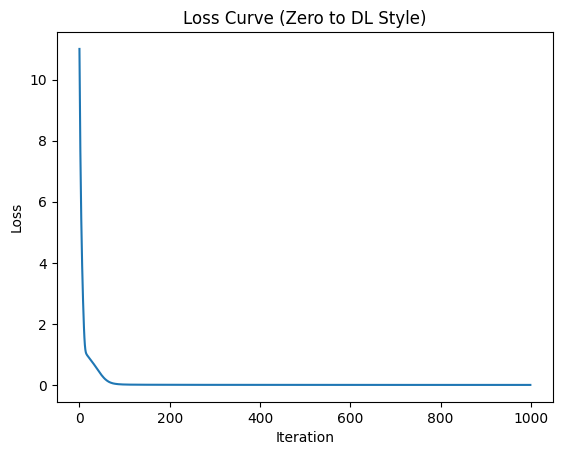

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# =========================================================================
# 1. 部品の定義 (ここが『ゼロからDL』の心臓部)
# =========================================================================


class Affine:
    """
    全結合層 (Fully Connected Layer)
    本では 'Affine' レイヤと呼ばれている。
    数式: Y = X・W + b
    """

    def __init__(self, input_size, output_size, weight_init_std=0.01):
        # 重み(W)とバイアス(b)の初期化
        # Heの初期値などは使わず、シンプルにガウス分布で初期化
        self.W = weight_init_std * np.random.randn(input_size, output_size)
        self.b = np.zeros(output_size)

        # 逆伝播のために、入力(x)と勾配(dW, db)を保存する変数
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        """順伝播: 入力xを受け取り、次へ渡す値outを計算"""
        self.x = x
        # 【重要】 行列の積 (Dot Product)
        out = np.dot(x, self.W) + self.b
        return out

    def backward(self, dout):
        """逆伝播: 上流からの勾配(dout)を受け取り、下流へ流す勾配(dx)を計算"""
        # 1. 重みWの勾配 (入力xを転置して掛ける)
        self.dW = np.dot(self.x.T, dout)

        # 2. バイアスbの勾配 (列方向の総和)
        self.db = np.sum(dout, axis=0)

        # 3. 入力xの勾配 (重みWを転置して掛ける) -> 前の層へ渡す
        dx = np.dot(dout, self.W.T)
        return dx


class Relu:
    """
    活性化関数 (ReLU)
    数式: x > 0 なら x, それ以外は 0
    """

    def __init__(self):
        self.mask = None

    def forward(self, x):
        # 0以下の場所をTrueにするマスクを作成
        self.mask = x <= 0
        out = x.copy()
        # 0以下の値を0にする
        out[self.mask] = 0
        return out

    def backward(self, dout):
        # 順伝播で0以下だった場所は、逆伝播でも信号(勾配)を通さない
        dout[self.mask] = 0
        dx = dout
        return dx


class MSELoss:
    """
    損失関数 (平均二乗誤差)
    数式: L = 1/2 * mean((y - t)^2)  ※本に合わせ1/2をつける版
    """

    def __init__(self):
        self.loss = None
        self.y = None  # 予測値
        self.t = None  # 正解データ

    def forward(self, y, t):
        self.y = y
        self.t = t
        # 誤差を計算
        self.loss = 0.5 * np.mean((y - t) ** 2)
        return self.loss

    def backward(self, dout=1):
        """
        一番最後の層なので、ここから逆伝播がスタートする。
        L = 1/2 * (y - t)^2 の微分は (y - t)
        """
        batch_size = self.t.shape[0]
        # データ数で割るのを忘れないこと
        dx = (self.y - self.t) / batch_size
        return dx


class SGD:
    """
    最適化手法 (確率的勾配降下法)
    数式: W = W - lr * dW
    """

    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        # 全てのパラメータ(W1, b1, W2, b2...)を更新
        for key in params.keys():
            params[key] -= self.lr * grads[key]


# =========================================================================
# 2. ネットワークの構築 (部品を組み立てる)
# =========================================================================
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size):
        # 重みの入れ物
        self.params = {}

        # 層の準備
        self.layers = {}

        # --- 1層目 (Affine1) ---
        self.layers["Affine1"] = Affine(input_size, hidden_size)
        self.params["W1"] = self.layers["Affine1"].W
        self.params["b1"] = self.layers["Affine1"].b

        # --- 活性化 (ReLU) ---
        self.layers["Relu1"] = Relu()

        # --- 2層目 (Affine2) ---
        self.layers["Affine2"] = Affine(hidden_size, output_size)
        self.params["W2"] = self.layers["Affine2"].W
        self.params["b2"] = self.layers["Affine2"].b

        # --- 最後の層 (Loss) ---
        self.last_layer = MSELoss()

    def predict(self, x):
        # 登録された層を順番に通すだけ
        for layer_name in ["Affine1", "Relu1", "Affine2"]:
            x = self.layers[layer_name].forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def gradient(self, x, t):
        # 1. 順伝播でLossを計算 (内部で各層にxが保存される)
        self.loss(x, t)

        # 2. 逆伝播 (Backpropagation) スタート！
        dout = 1
        dout = self.last_layer.backward(dout)  # Loss層から逆流開始

        # 層を逆順にする (Affine2 -> Relu1 -> Affine1)
        layers = ["Affine2", "Relu1", "Affine1"]

        for layer_name in layers:
            dout = self.layers[layer_name].backward(dout)

        # 計算された勾配を集める
        grads = {}
        grads["W1"] = self.layers["Affine1"].dW
        grads["b1"] = self.layers["Affine1"].db
        grads["W2"] = self.layers["Affine2"].dW
        grads["b2"] = self.layers["Affine2"].db

        return grads


# =========================================================================
# 3. 実行！ (データを流し込む)
# =========================================================================

# --- ダミーデータの作成 ---
# x: 入力 (例: 気温, 湿度) -> 2次元
# t: 正解 (例: アイスの売上) -> 1次元
np.random.seed(42)
X = np.random.rand(100, 2)  # 100個のデータ、入力2次元
T = 3 * X[:, 0] + 5 * X[:, 1] + 1  # 正解ルール: 3x1 + 5x2 + 1 (線形回帰)
T = T.reshape(-1, 1)  # 形を整える (100, 1)

# --- モデル準備 ---
input_size = 2
hidden_size = 10
output_size = 1
model = TwoLayerNet(input_size, hidden_size, output_size)
optimizer = SGD(lr=0.1)

loss_history = []

print("Training Start...")
for i in range(1000):  # 1000回学習
    # 1. 勾配を計算 (誤差逆伝播法！)
    grads = model.gradient(X, T)

    # 2. パラメータ更新 (SGD！)
    optimizer.update(model.params, grads)

    # ログ記録
    loss = model.loss(X, T)
    loss_history.append(loss)

    if i % 100 == 0:
        print(f"Iter {i}, Loss: {loss:.4f}")

# --- 結果確認 ---
print("\nTraining Finished.")
print(f"Final Loss: {loss:.4f}")

# 予測してみる
x_test = np.array([[0.5, 0.5]])  # 入力がそれぞれ0.5のとき
t_true = 3 * 0.5 + 5 * 0.5 + 1  # 正解は 1.5 + 2.5 + 1 = 5.0
y_pred = model.predict(x_test)

print(f"Input: {x_test}")
print(f"True Answer: {t_true}")
print(f"Prediction:  {y_pred[0][0]:.4f}")

# 学習曲線の表示
plt.plot(loss_history)
plt.title("Loss Curve (Zero to DL Style)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()